# Superhero movie analysis

In this notebook, we are exploring a dataset of superhero movies from imdb. We start with high level data analysis and pick on a few factors worth exploring to ask our stakeholders business questions to drive change.

In [10]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import numpy as np
import pymongo
import pprint
import json

In [11]:
# connecting to the database
# getting authorization to mongo cluster using read-only credentials
print(f"Connecting to movies database")
filename = r"C:\repos\auth.json"

with open(filename) as f:
    data = json.load(f)
    mongo_conn_st = data['mongodb3']

# set client using the connection string
client = pymongo.MongoClient(mongo_conn_st, authSource='mongodb')

# display server status
# requires permissions to see clusterMonitor
# serv_stat_resp= db.command('serverStatus')
# print(pprint.pprint(serv_stat_resp))

# connect to the movies database

db = client.movies 
print(f"Connection successful!")

Connecting to movies database
Connection successful!


In [12]:
# getting all superhero movies in the movies database
cursor = db['imdb_superheroes'].find({})

movie_df = pd.DataFrame(list(cursor))
movie_df.head()

,_id,ID,Title,Runtime,Rating,Votes,MPAARating,ReleaseYear,ReleaseMonth,ReleaseDay,...,Producer5,Company1,Company2,Company3,Director2,Company4,Company5,Director3,Director4,Director5
0,627fc3f1a499847d5c32ba34,6320628,Spider-Man: Far from Home,129.0,7.7,200908.0,PG-13,2019,6,26,...,Louis D'Esposito,Columbia Pictures,Pascal Pictures,Marvel Studios,NaN,NaN,NaN,NaN,NaN,NaN
1,627fc3f1a499847d5c32ba35,4154796,Avengers: Endgame,181.0,8.6,569782.0,PG-13,2019,4,22,...,Jon Favreau,Marvel Studios,NaN,NaN,Joe Russo,NaN,NaN,NaN,NaN,NaN
2,627fc3f1a499847d5c32ba36,6565702,Dark Phoenix,113.0,5.8,96585.0,PG-13,2019,6,5,...,Stan Lee,Twentieth Century Fox,Bad Hat Harry Productions,Donners' Company,NaN,Kinberg Genre,Marvel Entertainment,NaN,NaN,NaN
3,627fc3f1a499847d5c32ba37,468569,The Dark Knight,152.0,9.0,2105721.0,TV-14::(LV),2008,7,14,...,Christopher Nolan,Warner Bros.,Legendary Entertainment,Syncopy,NaN,DC Comics,NaN,NaN,NaN,NaN
4,627fc3f1a499847d5c32ba38,1477834,Aquaman,143.0,7.0,300580.0,PG-13,2018,11,26,...,Geoff Johns,DC Comics,DC Entertainment,Panoramic Pictures,NaN,Rodeo FX,The Safran Company,NaN,NaN,NaN


In [13]:
movie_df.columns

Index(['_id', 'ID', 'Title', 'Runtime', 'Rating', 'Votes', 'MPAARating',
       'ReleaseYear', 'ReleaseMonth', 'ReleaseDay', 'Budget', 'OpeningWeekend',
       'GrossSales', 'Genres', 'Cast1', 'Cast2', 'Cast3', 'Cast4', 'Cast5',
       'Cast6', 'Cast7', 'Cast8', 'Cast9', 'Cast10', 'Director1', 'Producer1',
       'Producer2', 'Producer3', 'Producer4', 'Producer5', 'Company1',
       'Company2', 'Company3', 'Director2', 'Company4', 'Company5',
       'Director3', 'Director4', 'Director5'],
      dtype='object')

## Cleansing the data

In [14]:
# create dictionary to append unique ratings for cleansing
rating_map = {
    "MPAARating": [],
    "SimpleRating": []
}

# iterate through all unique ratings in dataset
for rating in movie_df['MPAARating'].unique():
    # set inital rating in dataframe
    rating_map["MPAARating"].append(rating)
    try:
        # split at common delimiter
        rating_map["SimpleRating"].append(rating.split(":")[0])
    # null values return an error, set as unrated
    except AttributeError:
        rating_map["SimpleRating"].append("Unrated")

# convert to dataframe for merging
ratemap_df = pd.DataFrame(rating_map)
# merge dataframes
movie_df = pd.merge(left=movie_df, right=ratemap_df, how="left", on='MPAARating')
# normalizing the budgets as there is a strong skew
movie_df["Budg_Transf"] = np.log10(movie_df['Budget'])
# normalizing opening weekend as there is a strong skew
movie_df["OW_Transf"] = np.log10(movie_df['OpeningWeekend'])
# normalizing gross sales as there is a strong skew
movie_df["GS_Transf"] = np.log10(movie_df['GrossSales'])
# output
movie_df

,_id,ID,Title,Runtime,Rating,Votes,MPAARating,ReleaseYear,ReleaseMonth,ReleaseDay,...,Director2,Company4,Company5,Director3,Director4,Director5,SimpleRating,Budg_Transf,OW_Transf,GS_Transf
0,627fc3f1a499847d5c32ba34,6320628,Spider-Man: Far from Home,129.0,7.7,200908.0,PG-13,2019,6,26,...,NaN,NaN,NaN,NaN,NaN,NaN,PG-13,8.204120,7.966513,9.040187
1,627fc3f1a499847d5c32ba35,4154796,Avengers: Endgame,181.0,8.6,569782.0,PG-13,2019,4,22,...,Joe Russo,NaN,NaN,NaN,NaN,NaN,PG-13,8.551450,8.552808,9.446580
2,627fc3f1a499847d5c32ba36,6565702,Dark Phoenix,113.0,5.8,96585.0,PG-13,2019,6,5,...,NaN,Kinberg Genre,Marvel Entertainment,NaN,NaN,NaN,PG-13,8.301030,7.516249,8.402163
3,627fc3f1a499847d5c32ba37,468569,The Dark Knight,152.0,9.0,2105721.0,TV-14::(LV),2008,7,14,...,NaN,DC Comics,NaN,NaN,NaN,NaN,TV-14,8.267172,8.199787,9.001975
4,627fc3f1a499847d5c32ba38,1477834,Aquaman,143.0,7.0,300580.0,PG-13,2018,11,26,...,NaN,Rodeo FX,The Safran Company,NaN,NaN,NaN,PG-13,8.204120,7.860778,9.059927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,627fc3f1a499847d5c32bc13,1396235,Catalina: A New Kind of Superhero,98.0,3.0,14.0,Not Rated,2009,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,3.230449,NaN,NaN
480,627fc3f1a499847d5c32bc14,2597794,ACT Honour Walk,50.0,NaN,NaN,NaN,2013,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,NaN,NaN,NaN
481,627fc3f1a499847d5c32bc15,4306404,Oigye Eseo on Ulemae 9: Mujeok Ui Paiteo Ulemae,NaN,NaN,NaN,NaN,1993,10,6,...,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,NaN,NaN,NaN
482,627fc3f1a499847d5c32bc16,5737002,Translyatsia Safronova: Pro Konstruktory,65.0,1.2,12.0,NaN,2015,8,19,...,Konstantin Safronov,NaN,NaN,NaN,NaN,NaN,Unrated,NaN,NaN,NaN


In [15]:
# validating changes
movie_df.SimpleRating.unique()

array(['PG-13', 'TV-14', 'PG', 'R', 'TV-PG', 'TV-G', 'TV-Y7', 'Unrated',
       'Not Rated', 'TV-MA', 'G'], dtype=object)

## Exploring and visualizing the data

In [16]:
# looking at range of votes, and ultimately unhappy with the results
movie_df.sort_values(by='Votes', ascending=False)

,_id,ID,Title,Runtime,Rating,Votes,MPAARating,ReleaseYear,ReleaseMonth,ReleaseDay,...,Director2,Company4,Company5,Director3,Director4,Director5,SimpleRating,Budg_Transf,OW_Transf,GS_Transf
3,627fc3f1a499847d5c32ba37,468569,The Dark Knight,152.0,9.0,2105721.0,TV-14::(LV),2008,7,14,...,NaN,DC Comics,NaN,NaN,NaN,NaN,TV-14,8.267172,8.199787,9.001975
18,627fc3f1a499847d5c32ba46,1345836,The Dark Knight Rises,164.0,8.4,1410131.0,TV-14::(LV),2012,7,16,...,NaN,Syncopy,DC Comics,NaN,NaN,NaN,TV-14,8.397940,NaN,9.035405
26,627fc3f1a499847d5c32ba4e,372784,Batman Begins,140.0,8.2,1214926.0,TV-14::(V),2005,5,31,...,NaN,Legendary Entertainment,Patalex III Productions Limited,NaN,NaN,NaN,TV-14,8.176091,7.687934,8.573125
32,627fc3f1a499847d5c32ba54,848228,The Avengers,143.0,8.0,1201420.0,TV-14::(LV),2012,4,11,...,NaN,NaN,NaN,NaN,NaN,NaN,TV-14,8.342423,8.316890,9.181717
25,627fc3f1a499847d5c32ba4d,2015381,Guardians of the Galaxy,121.0,8.0,973244.0,TV-14::(LV),2014,7,21,...,NaN,NaN,NaN,NaN,NaN,NaN,TV-14,8.230449,7.974608,8.888840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,627fc3f1a499847d5c32bc0f,9547076,A Fanboys Tale,60.0,NaN,NaN,NaN,2018,8,7,...,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,2.698970,NaN,NaN
476,627fc3f1a499847d5c32bc10,417092,Robot Star Jjangga,76.0,NaN,NaN,NaN,1988,7,16,...,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,NaN,NaN,NaN
478,627fc3f1a499847d5c32bc12,472569,Thunder and Hurricane,105.0,NaN,NaN,NaN,2005,4,29,...,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,3.698970,NaN,NaN
480,627fc3f1a499847d5c32bc14,2597794,ACT Honour Walk,50.0,NaN,NaN,NaN,2013,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,Unrated,NaN,NaN,NaN


<AxesSubplot:>

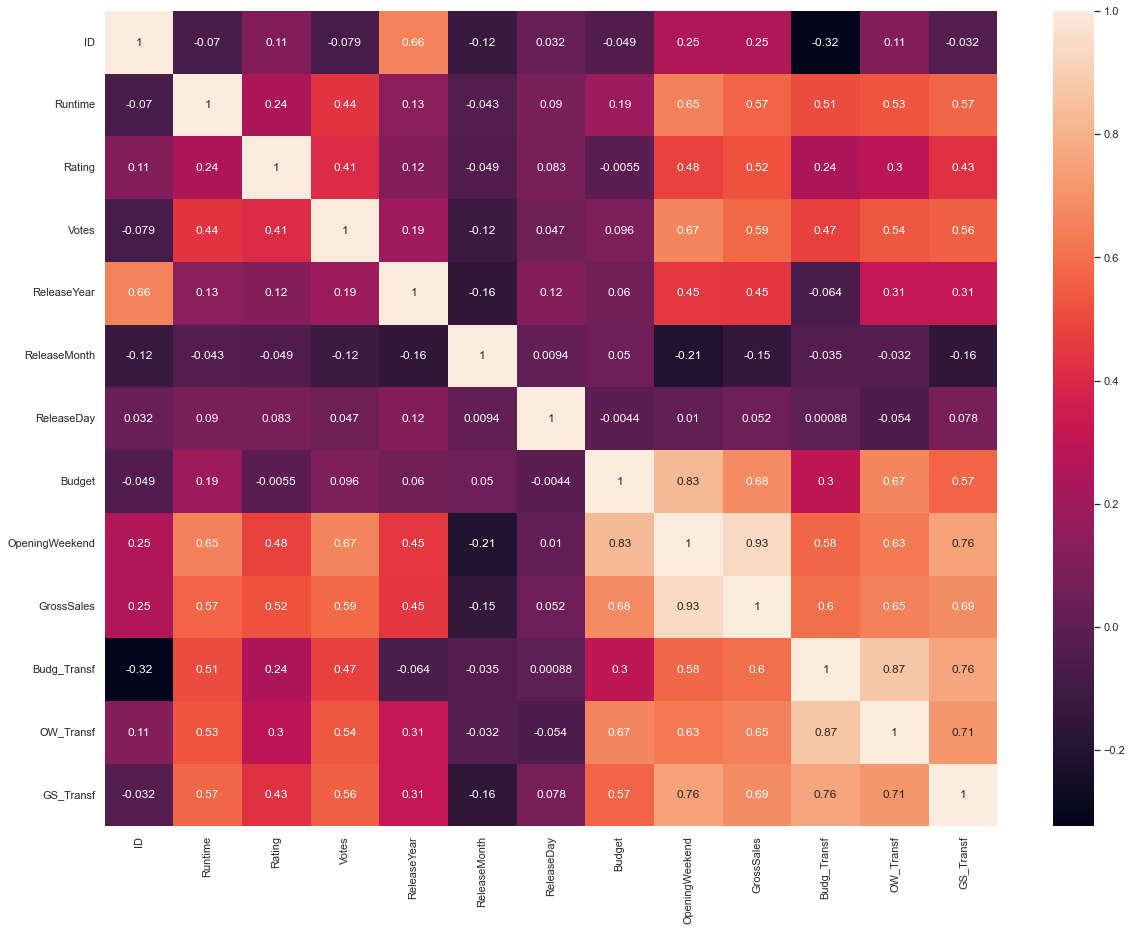

In [17]:
# utilizing correlation plots to find relationships
# set the canvas size
sns.set(rc={"figure.figsize":(20, 15)})

# do heatmap of correlations
sns.heatmap(movie_df.corr(), annot=True)

We can see there is a strong relationship between  OpeningWeekend and GrossSales. Another meaningful relationship appears to be OpeningWeekend and Budget. 

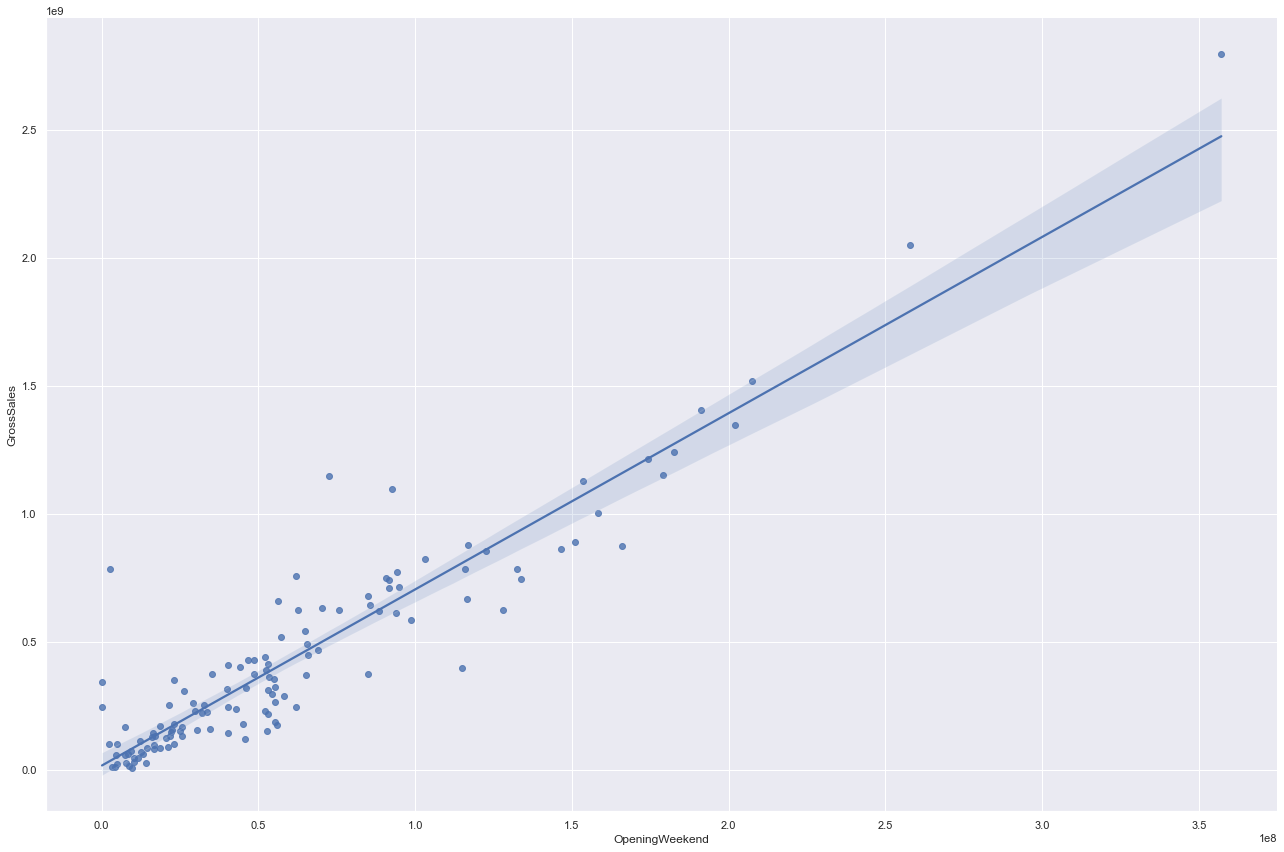

In [20]:
# create lineplot looking at observations between opening weekend and sales
# height replaces sns.set when available
sns.lmplot(x="OpeningWeekend", y="GrossSales", data=movie_df, height=12, aspect=1.5)

This graph shows that strong correlation we noted above in our correlation chart (0.93). I would like to add that to this chart!

# Conclusion

When looking to determine the success of a movie determined by the Gross Sales, we can inform our stakeholders that looking at the Opening Weekend sales to be a solid option. This also drove further questions, wondering if there are differences among our ratings we cleaned up above. So let's take a quick look at that.

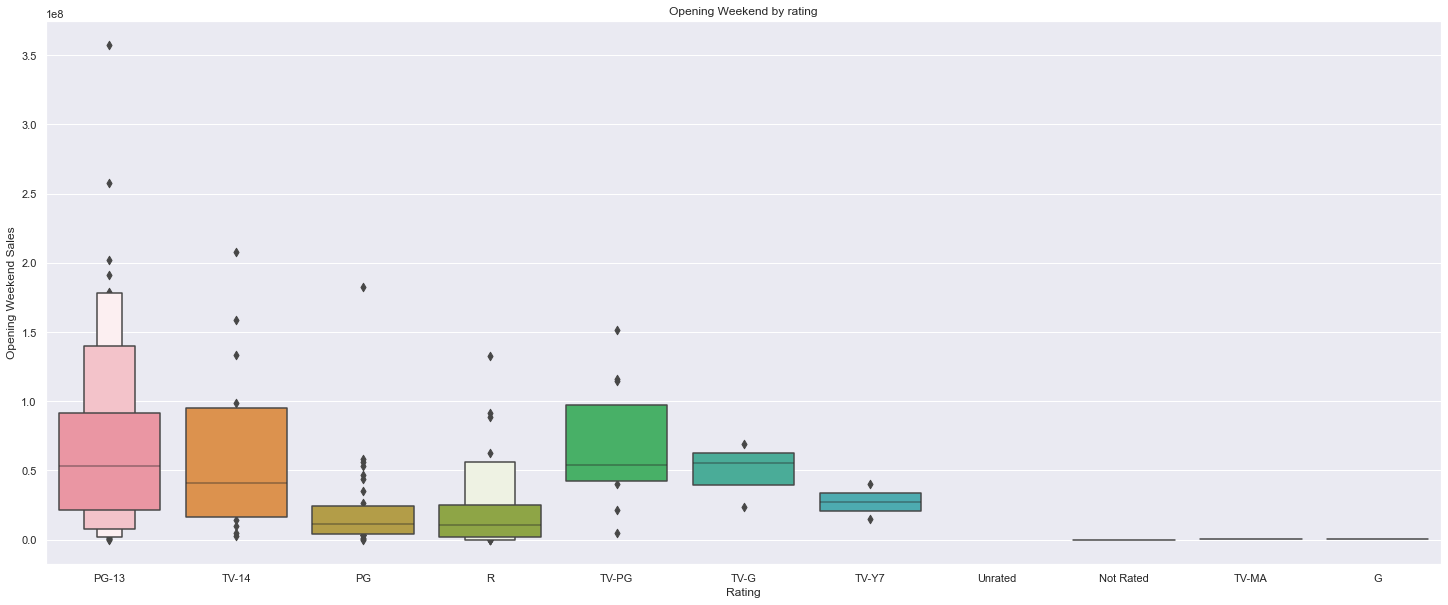

In [28]:
# boxplot looking at spread of opening weekend sales by rating
sns.set(rc={"figure.figsize":(25, 10)})
sns.boxenplot(data=movie_df, x="SimpleRating", y="OpeningWeekend")

plt.title('Opening Weekend by rating')
plt.xlabel('Rating')
plt.ylabel('Opening Weekend Sales')

plt.show()

We can observe many outliers through our ratings, with some strong centers. PG-13 is a great example, whereas Unrated shows significant spread. PG-13 looks most normal, with outliers

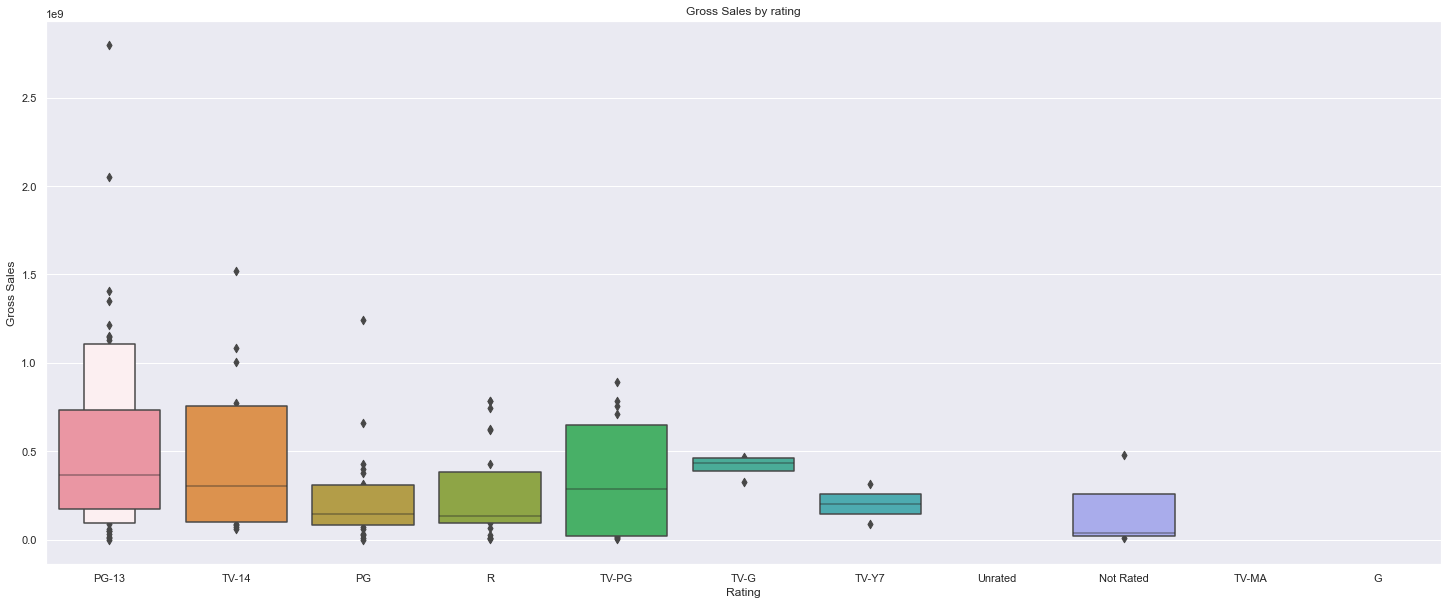

In [29]:
# boxplot looking at spread of opening weekend sales by rating
sns.set(rc={"figure.figsize":(25, 10)})
sns.boxenplot(data=movie_df, x="SimpleRating", y="GrossSales")

plt.title('Gross Sales by rating')
plt.xlabel('Rating')
plt.ylabel('Gross Sales')

plt.show()

This is where things get a little interesting. The spreads are pretty similar across the spectrum with PG-13 taking the cake. We can see TV-PG had significant growth - it makes sense given we have many older holiday movies that fall in that genre that get played during their designated period. 

Not Rated stands out most. It would be worth asking why this happens, and seeing what movies fell within this category to have such a significant impact.

When appraoching stakeholders, it would be worth looking at the overall theme, tone, and storyline of each movie. We can break each movie into a set of datapoints worth capturing to see what engages audiences most. What about PG-13 movies makes them so desireable and profitable? 

# End

### Extras

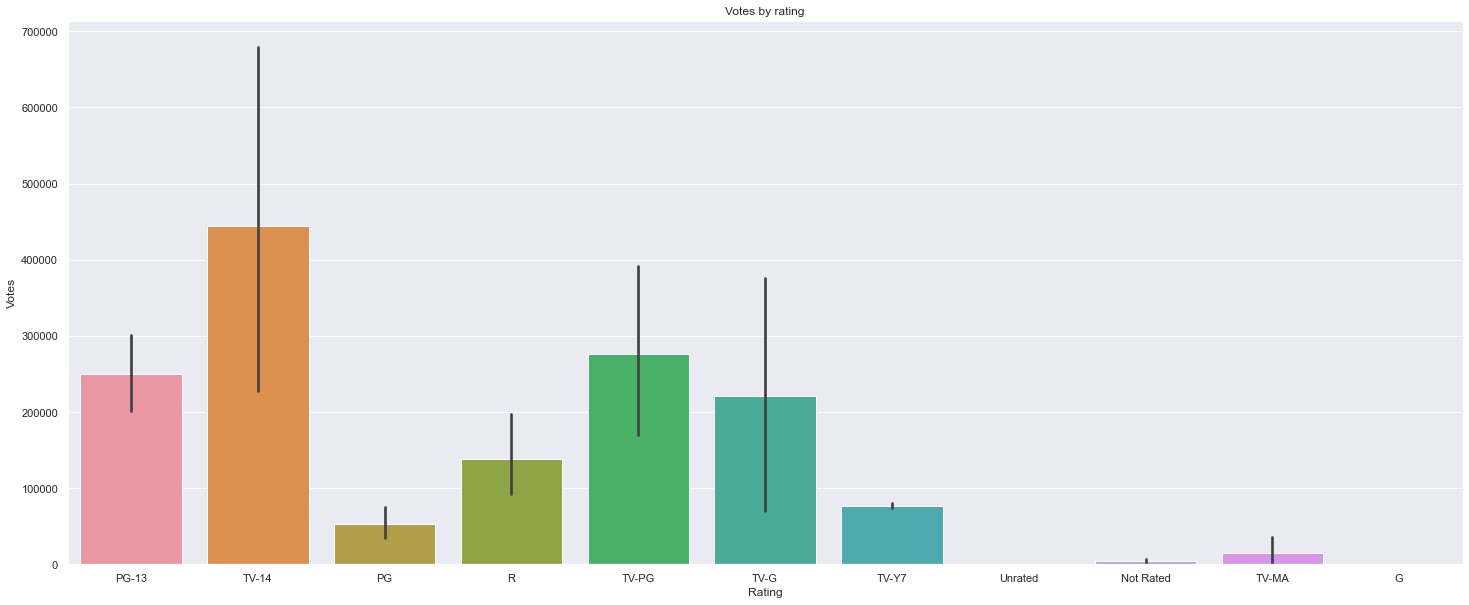

In [21]:
# show barplot of ratings and votes
sns.set(rc={"figure.figsize":(25, 10)})
sns.barplot(data=movie_df, x="SimpleRating", y="Votes")

plt.title('Votes by rating')
plt.xlabel('Rating')
plt.ylabel('Votes')

plt.show()

We can really see how popular TV-14 is by votes alone. PG-13 is also strong, almost equal to that of TV-PG. This leads me to question whether voters have a preference for non-Adult-rated media (TV-MA, R)

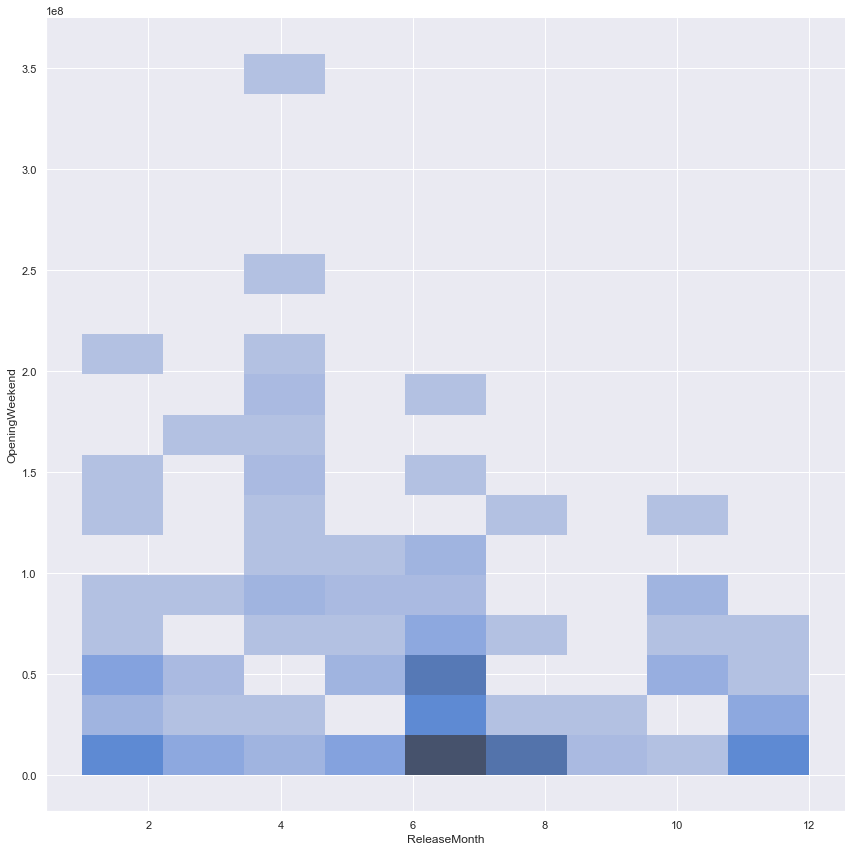

In [22]:
# create a distribution plot by release month
sns.displot(x="ReleaseMonth", y="OpeningWeekend", data=movie_df, height=12)

Playing around using ctrl+shift, I found this plot. I liked how it showed the density of where our data is by opening weekend sales by month. We can see just how strong of a month June is for movies. it makes sense being the beginning of summer!


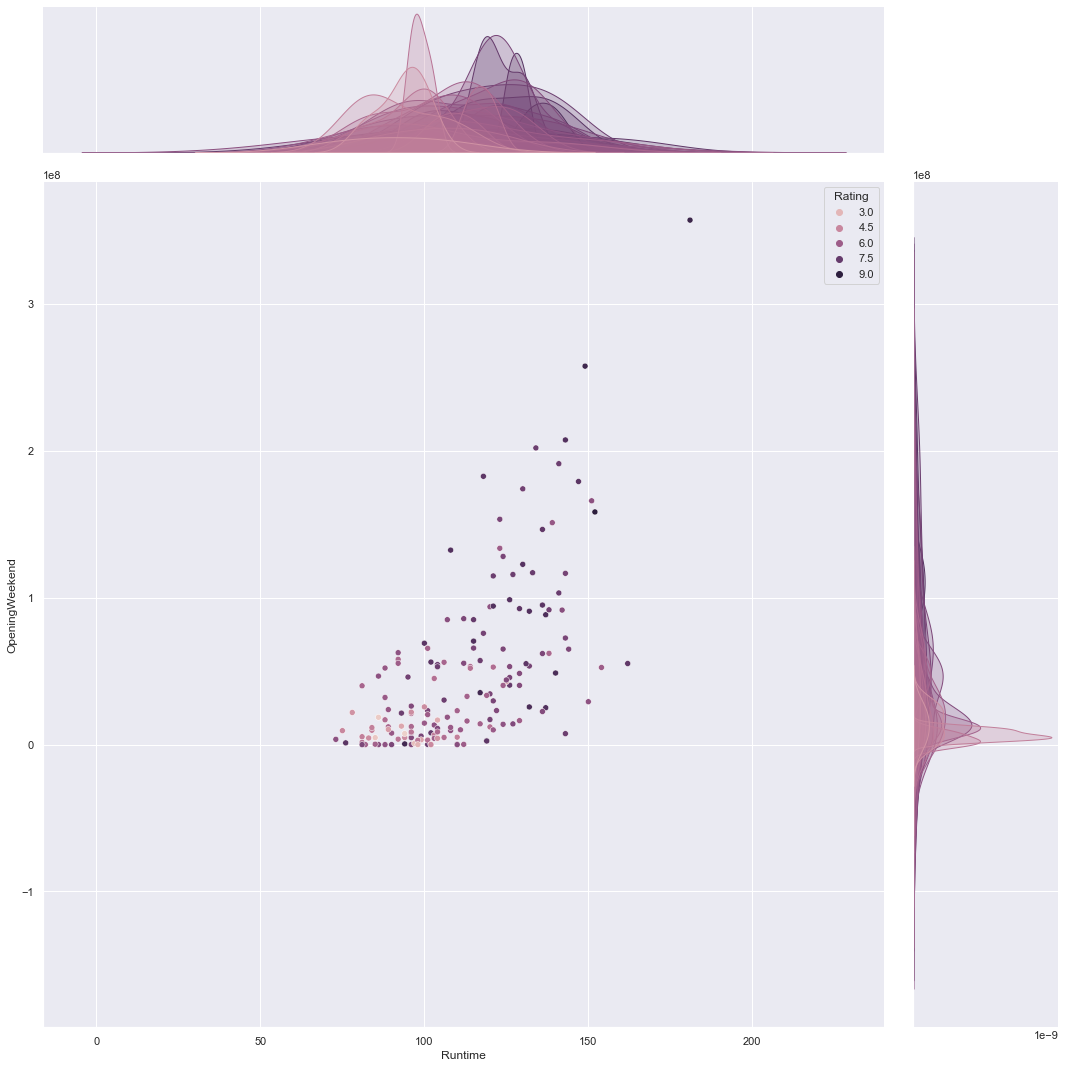

In [23]:
sns.jointplot(data=movie_df, x="Runtime", y="OpeningWeekend", hue="Rating", height=15, dropna=True)

I found a similar example online, but what I wanted to see was how well my transformed budget values compared to the runtime. We had a calculated correlation of 0.51 and this looks about right!

This is a great tool to partner with a correlation heatmap. The kernal density estimate plots are handsdown some of my favorite ways to vizualize data. I see this really helpful when needing to identify block designs when needed as well.

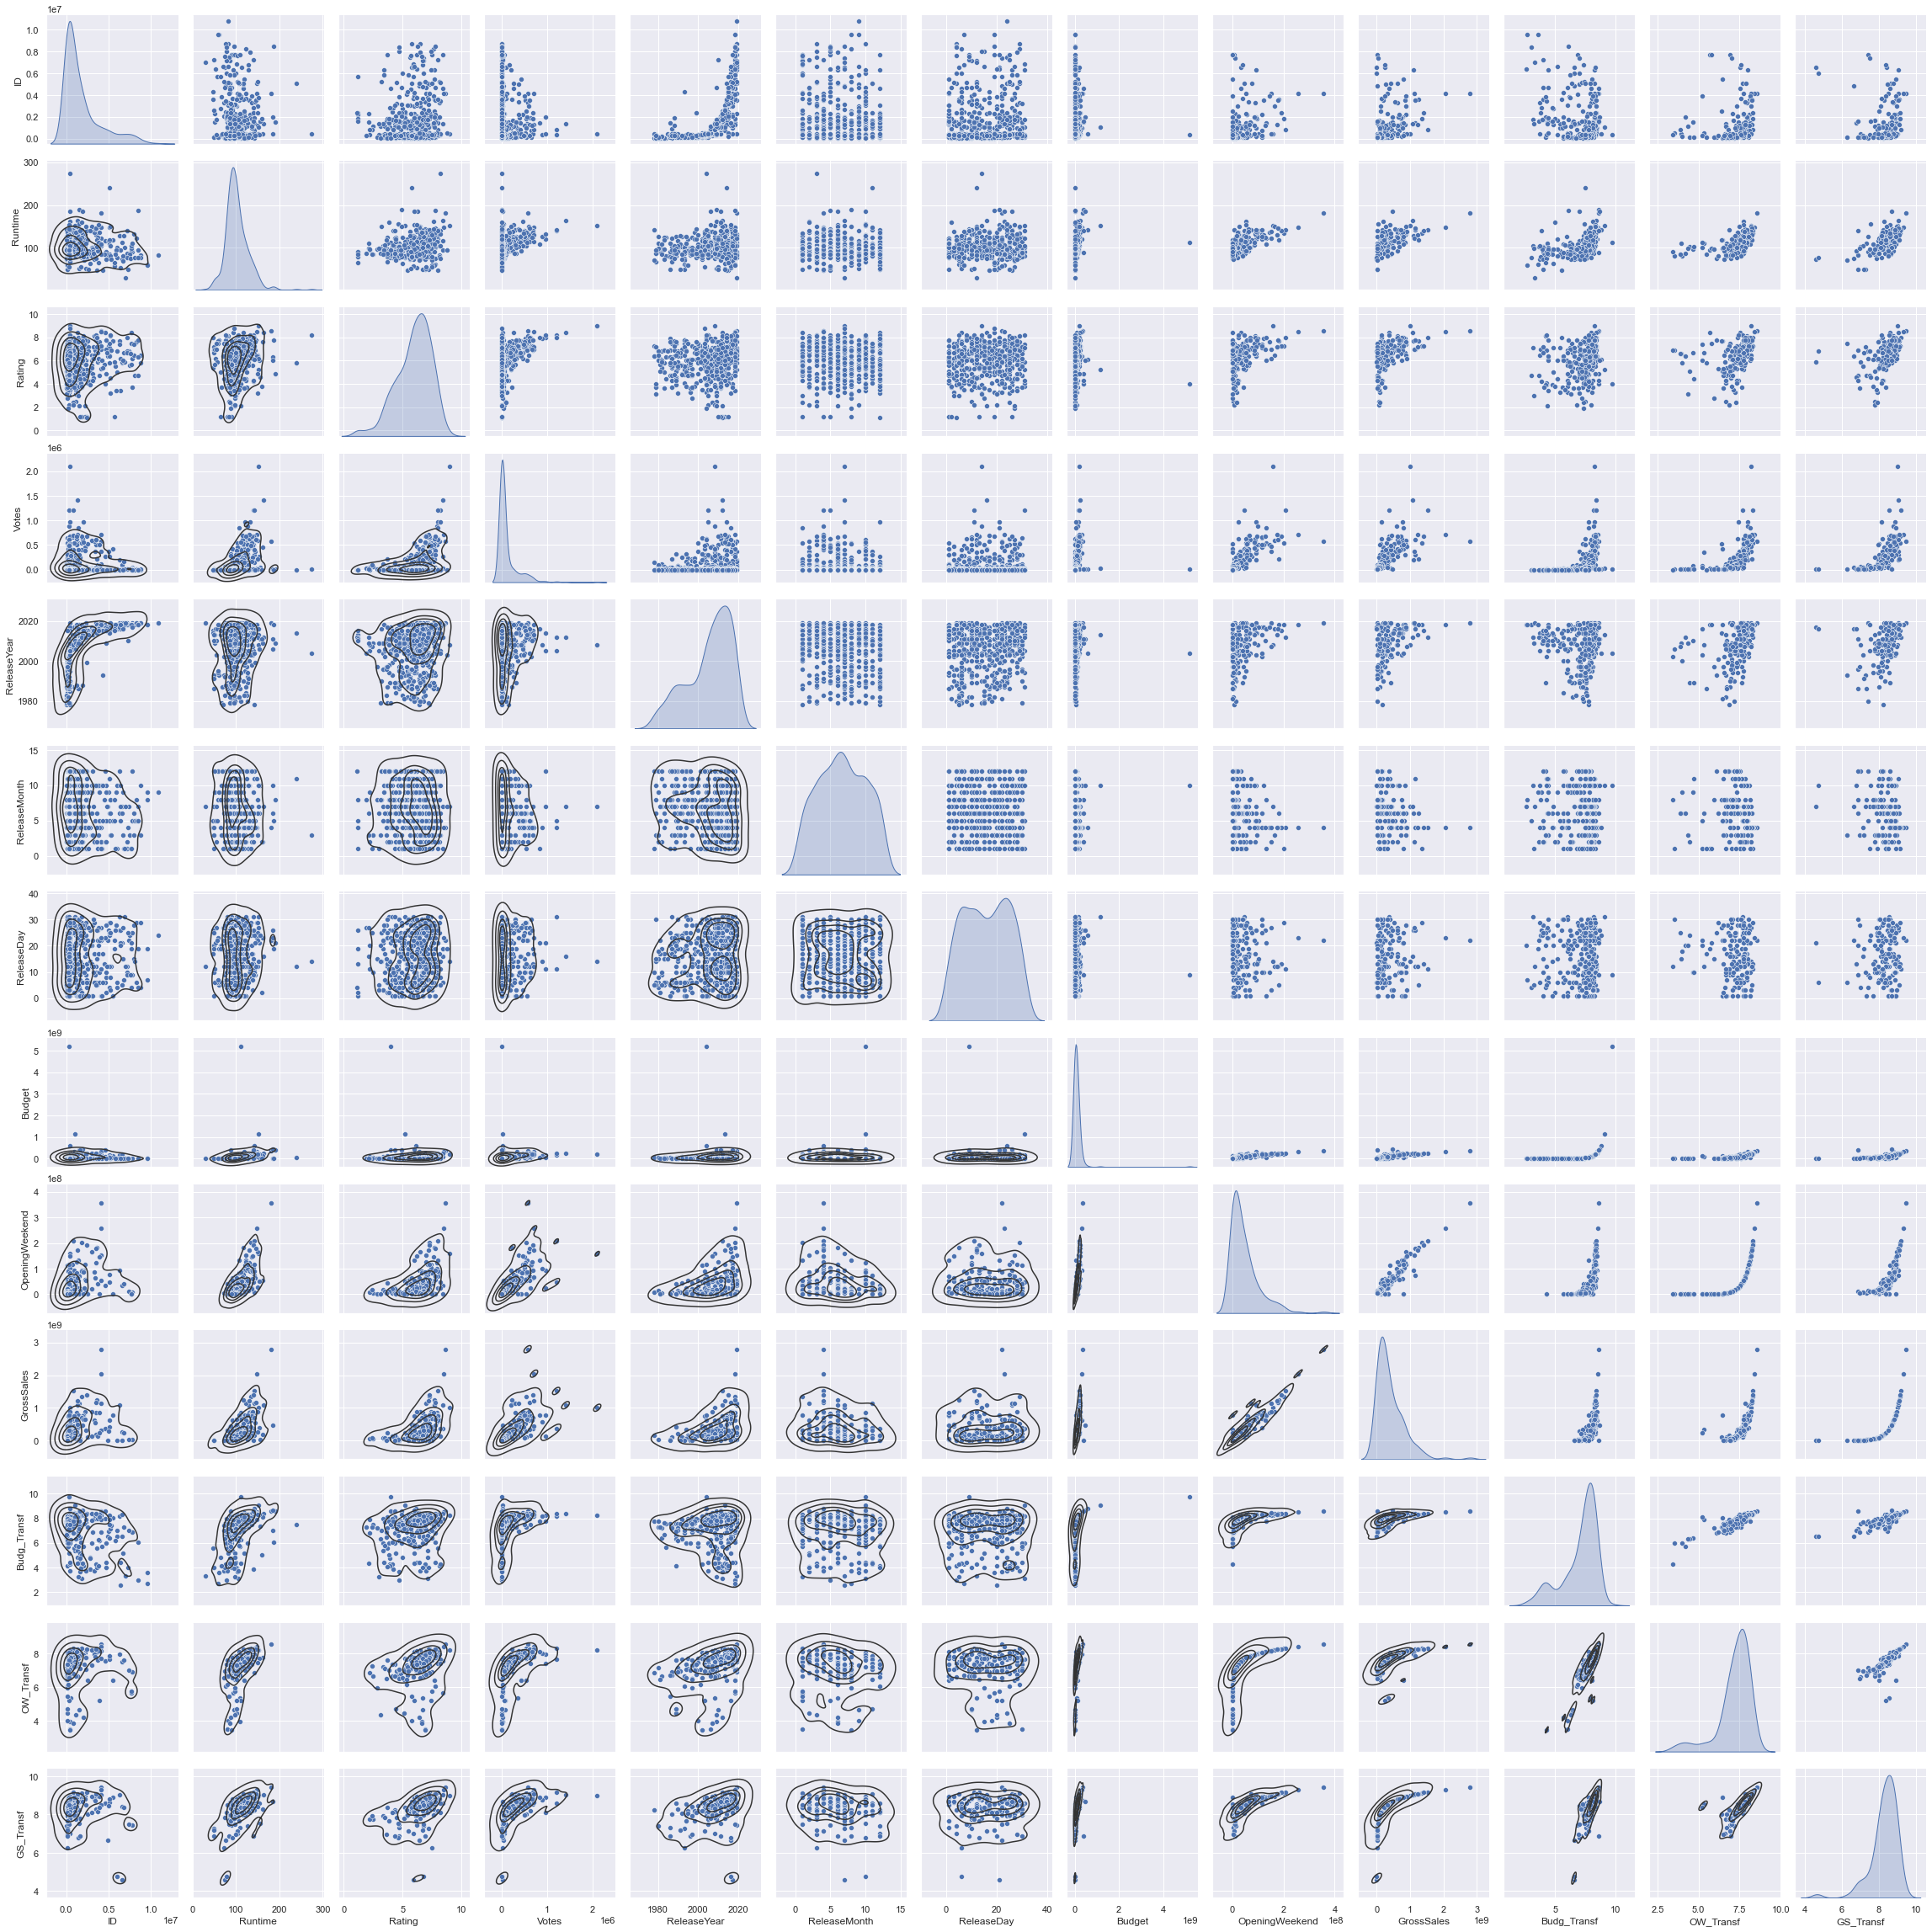

In [24]:
# create a pairplot of values and use the kernal density estimate plot - a "topographic" view of how dense our data is clustered/spread
g = sns.pairplot(movie_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=5, color=".2")

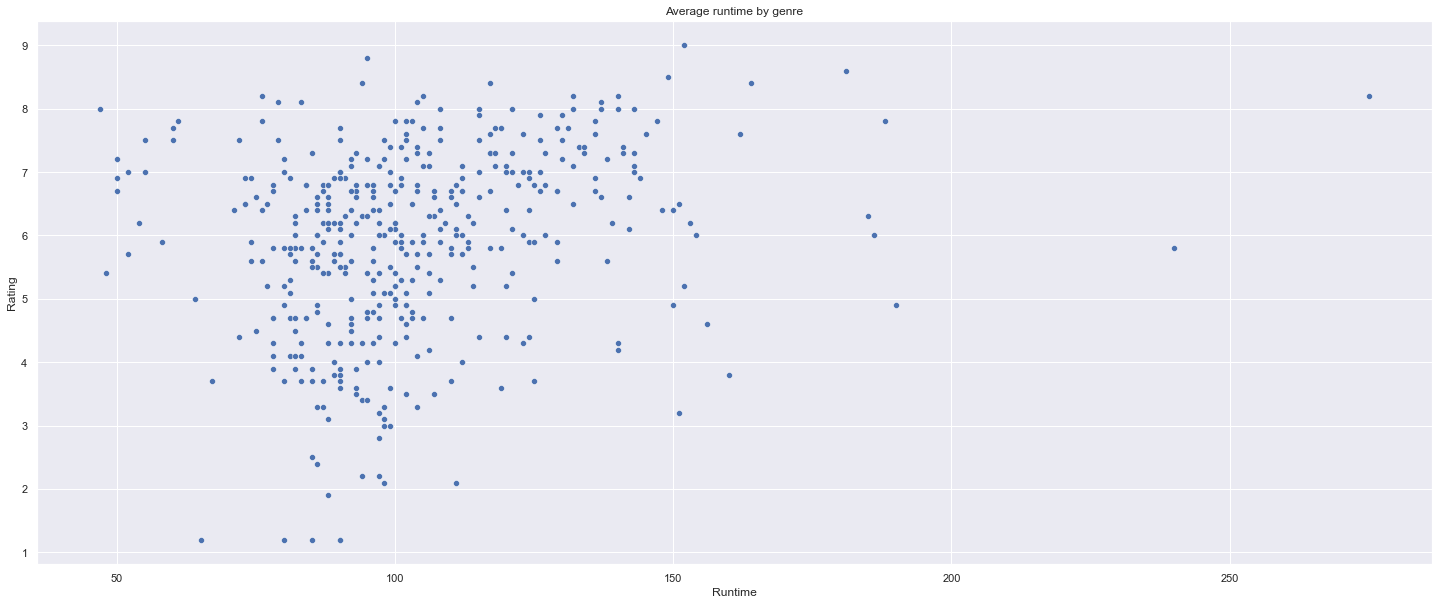

In [25]:
plt.figure(figsize=(25,10))

sns.scatterplot(data=movie_df, x="Runtime", y="Rating")

plt.title('Average runtime by genre')
plt.xlabel('Runtime')
plt.ylabel('Rating')

plt.show()

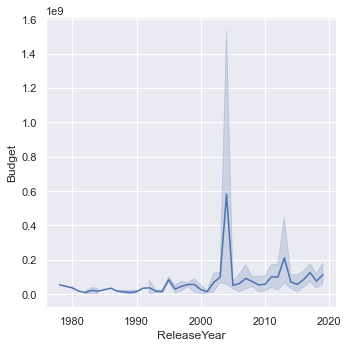

In [26]:
sns.relplot(x="ReleaseYear", y="Budget", kind="line", data=movie_df)

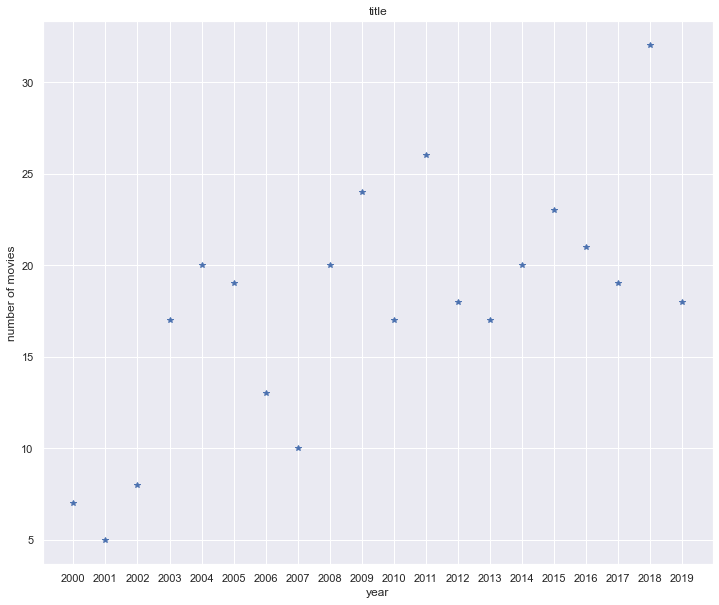

In [27]:
plt.figure(figsize=(12,10))
plt.title('title')
plt.xlabel('year')
plt.ylabel('number of movies')

df = movie_df["ReleaseYear"].groupby(movie_df.ReleaseYear).agg('count').loc[2000:]
plt.xticks(df.keys().to_list())

plt.plot(df, '*')
plt.show()